# Création du modèle d'estimation des prix

### Import des modules

In [78]:
import pandas as pd
import os
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


## Préparation des données

In [79]:
df_text = pd.read_csv(os.path.join('../..','data/4/raw_data/full_scrap_clean_features_only.csv'))
df_img = pd.read_csv(os.path.join('../..','data/4/raw_data/full_scrap_clean_images_only.csv'))

In [80]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6427 non-null   object
 1   image_1   6278 non-null   object
 2   image_2   5001 non-null   object
 3   image_3   4365 non-null   object
 4   image_4   3285 non-null   object
 5   image_5   2488 non-null   object
 6   image_6   1804 non-null   object
 7   image_7   1314 non-null   object
 8   image_8   961 non-null    object
 9   image_9   703 non-null    object
 10  image_10  402 non-null    object
 11  image_11  2 non-null      object
dtypes: object(12)
memory usage: 602.7+ KB


In [81]:
df_img = df_img.loc[:,df_img.isnull().mean()<0.5]

In [82]:
df_text['price']= df_text['price'].str.replace('€','').str.replace('.','').astype(float)
df_text = df_text.drop(columns='other_features')

In [83]:
df_text = df_text[(df_text['price']>100) & (df_text['price']< 8000)]

<Axes: xlabel='price', ylabel='Count'>

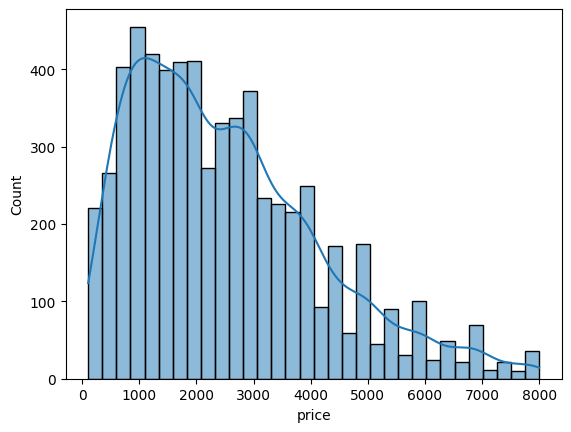

In [84]:
sns.histplot(df_text['price'], kde=True)


In [85]:
df_text['Nombres de vitesses'] = df_text['Nombres de vitesses'].str.extract(r'(\d+)').astype(float)

In [86]:
df_text['title_desc'] = (df_text['title'].fillna('') + "_" + df_text['description'].fillna(''))
df_text.drop(columns=['title','description'], inplace=True)
df_text=df_text[df_text['price']<10000]

In [87]:
df_text.drop(columns=['Couleurs principales'], inplace=True)

In [88]:
df_text['Année'] = datetime.date.today().year - df_text['Année']

In [89]:
size_mapping = {
    'XXS': 'XS',
    'XS': 'XS',
    'S': 'S',
    'S/M': 'S',
    'M': 'M',
    'M/L': 'M',
    'L': 'L',
    'L/XL': 'L',
    'XL': 'XL',
    'XXL': 'XXL',

    # Valeurs en cm
    '44 cm': 'XS',
    '45 cm': 'XS',
    '46 cm': 'XS',
    '47 cm': 'XS',
    '48 cm': 'XS',
    '49 cm': 'S',
    '50 cm': 'S',
    '51 cm': 'S',
    '52 cm': 'S',
    '53 cm': 'S',
    '54 cm': 'M',
    '55 cm': 'M',
    '56 cm': 'M',
    '57 cm': 'L',
    '58 cm': 'L',
    '59 cm': 'L',
    '60 cm': 'XL',
    '61 cm': 'XL',
    '62 cm': 'XL',
    '63 cm': 'XXL',
    '64 cm': 'XXL',

    # Autres cas
    'Unique': 'M',
    'EXPERT': 'XL',
    'PRO': 'XL',
    'PRO XL': 'XL',
    'JUNIOR': 'XS'
}
df_text['Taille du cadre'] = df_text['Taille du cadre'].map(size_mapping)

In [90]:
df_text['Taille du cadre'].value_counts()

Taille du cadre
M      2750
S      1516
L       979
XS      379
XL      226
XXL      19
Name: count, dtype: int64

In [91]:
df_text.loc[~(df_text['Diametre roues'] == '700 / 28"'), 'Diametre roues'] = 'Autre'

In [92]:
df_text['Diametre roues'].value_counts()

Diametre roues
700 / 28"    4698
Autre        1528
Name: count, dtype: int64

## Preprocessing

In [93]:
X = df_text.drop(columns=['price','id'])
y= df_text['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Pipeline text

In [94]:
df_text.head(3)

,id,price,Année,État,Groupe,Taille du cadre,Diametre roues,Matière principale,Type de freinage,Nombres de vitesses,"Groupe électrique (AXS, Di2, eTap, ..)",Pratique,title_desc
0,i_00000,4200.0,4.0,Très bon état,Shimano Ultegra Di2,L,"700 / 28""",Carbone,Disques,11.0,Oui,NaN,Colnago V3rs - COLNAGO - 63000_État nickel (pr...
1,i_00001,6700.0,0.0,Neuf,Shimano Dura Ace Di2,L,"700 / 28""",Carbone,Disques,12.0,NaN,Route,LOOK 795 BLADE RS - LOOK - 67720_Vends : LOOK...
2,i_00002,250.0,45.0,Très bon état,NaN,L,"700 / 28""",Acier,NaN,NaN,NaN,Piste,Vélo de piste Lejeune vintage - LEJEUNE - 7895...


In [95]:
df_text['Type de freinage'].unique()

array(['Disques', nan, 'Patins', 'Disque', 'Tambours'], dtype=object)

In [96]:
cat_cols_onehot = [
    'Groupe',
    'Taille du cadre',
    'Diametre roues',
    'Matière principale',
    'Type de freinage',
    'Pratique',
    'Groupe électrique (AXS, Di2, eTap, ..)']
cat_cols_ordinal = ['État']
num_cols = ['Année',
            'Nombres de vitesses']
bool_cols = ['Groupe électrique (AXS, Di2, eTap, ..)']

In [97]:
boolean_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Non')),
    ('encoder', OrdinalEncoder(categories=[['Non','Oui']],handle_unknown='use_encoded_value',unknown_value=-1))
])
boolean_pipeline

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='Non', strategy='constant')),
                ('encoder',
                 OrdinalEncoder(categories=[['Non', 'Oui']],
                                handle_unknown='use_encoded_value',
                                unknown_value=-1))])

In [98]:
df_text['État'].value_counts()

État
Très bon état    3165
Comme neuf       1329
Bon état          988
Neuf              701
Usé                43
Name: count, dtype: int64

In [99]:
cat_pipeline_onehot = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
cat_pipeline_ordinal = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(
    categories=[['Usé', 'Bon état', 'Très bon état','Comme neuf', 'Neuf']],
    handle_unknown='use_encoded_value',
    unknown_value=-1))
])

In [100]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('encoder', RobustScaler())
])

In [101]:
preprocessor = ColumnTransformer(transformers=[
    ('cat_oo', cat_pipeline_onehot, cat_cols_onehot),
    ('cat_or',cat_pipeline_ordinal, cat_cols_ordinal),
    ('num', num_pipeline, num_cols),
    ('text', TfidfVectorizer(max_features=1000),'title_desc'),
    ('bool', boolean_pipeline, bool_cols)
], remainder='drop')
preprocessor

ColumnTransformer(transformers=[('cat_oo',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Groupe', 'Taille du cadre', 'Diametre roues',
                                  'Matière principale', 'Type de freinage',
                                  'Pratique',
                                  'Groupe électrique (AXS, Di2, eTap, ..)']),
                                ('cat_or',
                                 Pipeline(steps=[('imputer',
                                                  Simple...
                                                 ('encoder', RobustScaler())]),
                                 ['Année', 'Nombres de vitesses']),
                                ('text', TfidfVectorizer(max_features=1000),
                                 'title_desc'),
                                ('bool',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Non',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['Non',
                                                                              'Oui']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Groupe électrique (AXS, Di2, eTap, ..)'])])

In [102]:
sgd_model = SGDRegressor(max_iter=1000,
                         tol=1e-3,
                         random_state=42)


In [103]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', sgd_model)
])
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_oo',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Groupe', 'Taille du cadre',
                                                   'Diametre roues',
                                                   'Matière principale',
                                                   'Type de freinage',
                                                   'Pratique',
                                                   'Groupe électrique (AXS, '
                                                   'Di2, eTap, ..)']),
                                                 ('cat_or'...
                                                   'Nombres de vitesses']),
                                                 ('text',
                                                  TfidfVectorizer(max_features=1000),
                                                  'title_desc'),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Non',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['Non',
                                                                                               'Oui']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Groupe électrique (AXS, '
                                                   'Di2, eTap, ..)'])])),
                ('model', SGDRegressor(random_state=42))])

In [104]:
grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1],
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__l1_ratio': [0.15, 0.5, 0.9]  # utile seulement si elasticnet est sélectionné
}

In [105]:
gridsearch = GridSearchCV(
    model_pipeline,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_oo',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Groupe',
                                                                          'Taille '
                                                                          'du '
                                                                          'cadre',
                                                                          'Diametre '
                                                                          'roues',
                                                                          'Matière '
                                                                          'principale',
                                                                          'Type '
                                                                          'de '
                                                                          'freinage',
                                                                          'Pratique',
                                                                          'Groupe '
                                                                          '...
                                                                                          OrdinalEncoder(categories=[['Non',
                                                                                                                      'Oui']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Groupe '
                                                                          'électrique '
                                                                          '(AXS, '
                                                                          'Di2, '
                                                                          'eTap, '
                                                                          '..)'])])),
                                       ('model',
                                        SGDRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.001, 0.01, 0.1, 1],
                         'model__l1_ratio': [0.15, 0.5, 0.9],
                         'model__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error')

In [106]:
print("Meilleurs hyperparamètres :", gridsearch.best_params_)
print("MAE sur le test set :", mean_absolute_error(y_test, gridsearch.predict(X_test)))

Meilleurs hyperparamètres : {'model__alpha': 0.001, 'model__l1_ratio': 0.15, 'model__penalty': 'l1'}
MAE sur le test set : 639.0449631960552


In [107]:
model_pipeline_rf = Pipeline([
        ('preprocessor', preprocessor),
        ('model_rf', RandomForestRegressor(random_state=42))
    ])

In [108]:
param_grid_rf = {
    'model_rf__n_estimators': [50, 100, 200],
    'model_rf__max_depth': [None, 10, 20],
    'model_rf__max_features': ['sqrt', 'log2']
}

In [109]:
gridsearch_rf = GridSearchCV(
    model_pipeline_rf,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
gridsearch_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_oo',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Groupe',
                                                                          'Taille '
                                                                          'du '
                                                                          'cadre',
                                                                          'Diametre '
                                                                          'roues',
                                                                          'Matière '
                                                                          'principale',
                                                                          'Type '
                                                                          'de '
                                                                          'freinage',
                                                                          'Pratique',
                                                                          'Groupe '
                                                                          '...
                                                                                          OrdinalEncoder(categories=[['Non',
                                                                                                                      'Oui']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Groupe '
                                                                          'électrique '
                                                                          '(AXS, '
                                                                          'Di2, '
                                                                          'eTap, '
                                                                          '..)'])])),
                                       ('model_rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model_rf__max_depth': [None, 10, 20],
                         'model_rf__max_features': ['sqrt', 'log2'],
                         'model_rf__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [110]:
best_model = gridsearch_rf.best_estimator_
best_model.fit(X_train, y_train)  # pas nécessaire mais parfois utile

mean_absolute_error(y_test,best_model.predict(X_test))

615.2698577256746

In [111]:
# Prédictions
y_pred = gridsearch_rf.predict(X_test)

# Construction du DataFrame final
df_pred = X_test.copy()
df_pred["true_price"] = y_test.values
df_pred["predicted_price"] = y_pred
df_pred["absolute_error"] = abs(df_pred["true_price"] - df_pred["predicted_price"])

# Rajouter l'ID depuis df_text
df_pred["id"] = df_text.loc[X_test.index, "id"].values

# Export vers Excel
df_pred.to_excel("../../data/4/predictions_rf_features.xlsx", index=False)